In [1]:
import pylab
from pylab import *

import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


import numpy as np
from numpy.random import multivariate_normal


from scipy import stats
from scipy.interpolate import interp1d as int1d


import random


from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy import constants as const

In [2]:
# Read data

hdul = fits.open('DR7.fits')
data = hdul[1].data  # First extension is the table!
ra = data['RA']
dec = data['DEC']
z = data['REDSHIFT']
mass = data['LOGBH']

# Restrict the data we analize. 
### $\log(M_{BH})>7\;\;,\;\;z<5\;\;,\;\;\rm{ra}\in[120,240]\;\;,\;\;\rm{dec}\in[10,50]$

In [25]:
#define restricted parameters and indicators
m_min=np.log10(6*10**9)
z_max=2.5
z_min=0.4
ra_min=120
ra_max=240
dec_min=10
dec_max=50
inds=(mass>m_min) & (z < z_max) & (dec > dec_min) & (dec < dec_max) & (ra > ra_min) & (ra < ra_max) & (z > z_min) 

# restricted arrays
z_new=z[inds]
dec_new=dec[inds]
ra_new=ra[inds]
mass_new=mass[inds]

# comoving distance to each point
dist_new=cosmo.comoving_distance(z_new)

# sky coordinate of each point.
QSO_coord = SkyCoord(ra_new*u.degree, dec_new*u.degree, frame='icrs', distance = dist_new)




def nearest(coord):
    return np.sort(coord.separation_3d(QSO_coord).value)[1]

# dist_arr=np.array([np.sort(coord.separation_3d(QSO_coord).value)[1] for x in QSO_coord])



### Simple geometirc calculation: $$n_Q=\frac{N_Q}{\rm Vol}\;\;;\;\;d=\left(\frac{4\pi}{3}n_Q\right)^{-1/3}$$
#### The volume is that of a truncated rectangular pyramid, where the ratio of the lower and upper base sides are denoted $r$.
#### The volume is thus given by $$V=\frac{HLW}{3}(1-r^3),$$ where $H,\,L,\,W$ are the hight, length and width of the un-truncated pyramid. We don't know the hight of the pyramid, but we do know the length of the edeg, $D$. $D$ obyes $$D^2=(1-r)^2\left[H^2+\frac{1}{4}\left(W^2+L^2\right)\right].$$ The volume is therefore given by $$V=\frac{1}{3}(1-r^3)LW\sqrt{\left(\frac{D}{1-r}\right)^2-\frac{L^2+W^2}{4}}$$

In [169]:
def Vol(zmin,zmax):
    # Define 2 points at z_min and 3 at z_max that allows us to calculate the volume
    pt1_min=SkyCoord(ra_min*u.degree, dec_min*u.degree, frame='icrs', distance = cosmo.comoving_distance(zmin))
    pt2_min=SkyCoord(ra_max*u.degree, dec_min*u.degree, frame='icrs', distance = cosmo.comoving_distance(zmin))
    pt1_max=SkyCoord(ra_min*u.degree, dec_min*u.degree, frame='icrs', distance = cosmo.comoving_distance(zmax))
    pt2_max=SkyCoord(ra_max*u.degree, dec_min*u.degree, frame='icrs', distance = cosmo.comoving_distance(zmax))
    pt3_max=SkyCoord(ra_min*u.degree, dec_max*u.degree, frame='icrs', distance = cosmo.comoving_distance(zmax))

    # And the distances
    D=pt1_min.separation_3d(pt1_max)
    L=pt1_max.separation_3d(pt2_max)
    W=pt1_max.separation_3d(pt3_max)
    r=pt1_min.separation_3d(pt2_min)/pt1_max.separation_3d(pt2_max)
    #The Volume
    return (1-r**3)*L*W*np.sqrt((D/(1-r))**2-(L**2+W**2)/4)





## A small test
#(4*np.pi*len(z_new)/(3*V))**(-1/3)
Vol(1.5,2)

<Quantity 2.76156688e+10 Mpc3>

### Simple geometirc calculation: $$n_Q=\frac{N_Q}{\rm Vol}\;\;;\;\;d=\left(\frac{4\pi}{3}n_Q\right)^{-1/3}$$

In [30]:
def Vol(zmin,zmax):
    #Volume of a spherical co-moving shell
    Vsh=(cosmo.comoving_volume(zmax)-cosmo.comoving_volume(zmin))
    #Volume of a 1 steradians section of the shell
    Vstr=Vsh/(4*np.pi)
    #The relevant solid angle
    sa=radians((ra_max-ra_min))*(np.cos(radians(dec_min))-np.cos(radians(dec_max)))
    
    #The Volume
    return Vstr*sa

(len(mass_new)/(intminL(m_min)*4*np.pi*Vol(z_min,z_max)/3))**(-1/3)

<Quantity 81.86967914 Mpc>

In [ ]:
len(mass_new[mass_]

### A recursive function to the rescue

In [18]:
def NM_Mrange(mlis,mmin,mmax,deltm):
    if mmin>mmax:
        return []
    else:
        return np.append(len(mlis[mlis>mmin]),NM_Mrange(mlis,mmin+deltm,mmax,deltm))

def NM_Zrange(mlis,mmin,mmax,deltm,zlis,zmin,zmax,deltz):
    if zmin+deltz>zmax:
        return NM_Mrange(mass_new,7,10,deltm)*0
    else:
        return np.vstack((NM_Mrange(mlis[(zlis>zmin) & (zlis<zmin+deltz)],mmin,mmax,deltm),NM_Zrange(mlis,mmin,mmax,deltm,zlis,zmin+deltz,zmax,deltz)))
    
def Vol_Zrange(zmin,zmax,deltz):
    if zmin+deltz>zmax:
        return []
    else:
        return np.append(Vol(zmin,zmin+deltz).value,Vol_Zrange(zmin+deltz,zmax,deltz))
    

/Users/nadavoutmezguine/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in power
  """Entry point for launching an IPython kernel.


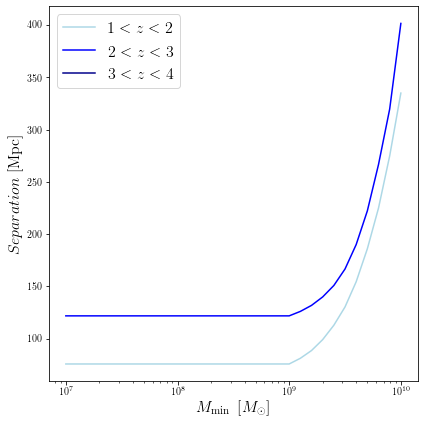

In [19]:
tab=(4*np.pi*NM_Zrange(mass_new,7,10,.1,z_new,1,5,1)[:-1]/Vol_Zrange(1,5,1)[:,None]/3)**(-1/3)
mlis=np.arange(7,10.1,.1)
zlis=np.arange(1,5,1)

colis=['lightblue','blue','darkblue','red']


fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

for x in range(len(tab)-1):
    ax.semilogx(10**mlis,tab[x,:], label=f'${zlis[x]}<z<{zlis[x+1]}$',c=colis[x])

    



ax.legend(loc='upper left',fontsize=16)    
ax.set_xlabel(r'$M_{\rm min}\;\left[{M_\odot}\right]$', fontsize=16)
ax.set_ylabel('$Separation\;[\\rm{ Mpc}]$', fontsize=16)
  
plt.savefig('d_vs_Mz.pdf')
plt.show()


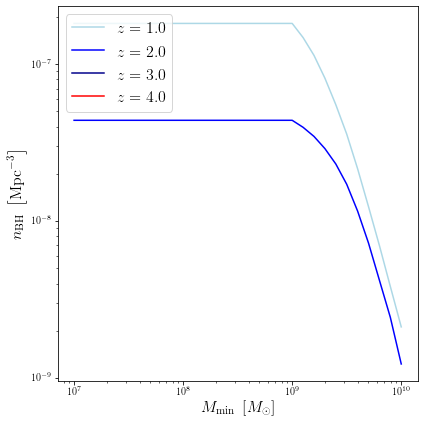

In [20]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

for x in range(len(tab)):
    ax.loglog(10**mlis,(4*np.pi*tab[x,:]**3)**(-1), label=r'$z=%1.1f$' % zlis[x],c=colis[x])

    



ax.legend(loc='upper left',fontsize=16)    
ax.set_xlabel(r'$M_{\rm min}\;\left[{M_\odot}\right]$', fontsize=16)
ax.set_ylabel(r'$n_{\rm BH}\;\left[{\rm Mpc}^{-3}\right]$', fontsize=16)
  
plt.savefig('n_vs_Mz.pdf')
plt.show()

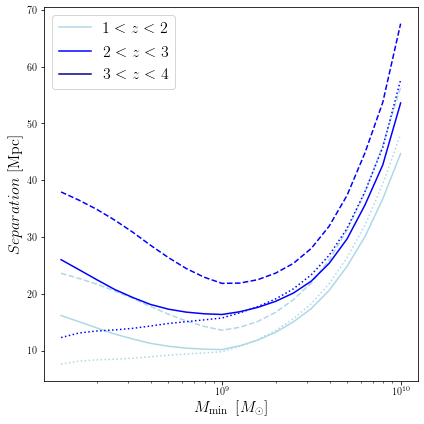

In [21]:
lam06=np.loadtxt(open('../digi/lam06.csv'), delimiter=",")
lam03=np.loadtxt(open('../digi/lam03.csv'), delimiter=",")
minL=np.loadtxt(open('../digi/minL.csv'), delimiter=",")
lam03=np.vstack((lam03,[lam03[-1,0]+5,lam03[-1,1]]))
lam06=np.vstack((lam06,[lam06[-1,0]+5,lam06[-1,1]]))
minL=np.vstack((minL,[minL[-1,0]+5,minL[-1,1]]))
intlam06=int1d(lam06[:,0]-0.02,10**lam06[:,1],kind=1)
intlam03=int1d(lam03[:,0]-0.01,10**lam03[:,1],kind=1)
intminL=int1d(minL[:,0],10**minL[:,1],kind=1)

fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

for x in range(len(tab)-1):
    ax.semilogx(10**mlis[11:],tab[x,11:]*intlam06(mlis[11:])**(1/3), label=f'${zlis[x]}<z<{zlis[x+1]}$',c=colis[x])
    ax.semilogx(10**mlis[11:],tab[x,11:]*intlam03(mlis[11:])**(1/3), ls='dashed',c=colis[x])
    ax.semilogx(10**mlis[11:],tab[x,11:]*intminL(mlis[11:])**(1/3), ls='dotted',c=colis[x])

    



ax.legend(loc='upper left',fontsize=16)    
ax.set_xlabel(r'$M_{\rm min}\;\left[{M_\odot}\right]$', fontsize=16)
ax.set_ylabel('$Separation\;[\\rm{ Mpc}]$', fontsize=16)
  
plt.savefig('d_vs_Mz_fopt.pdf')
plt.show()

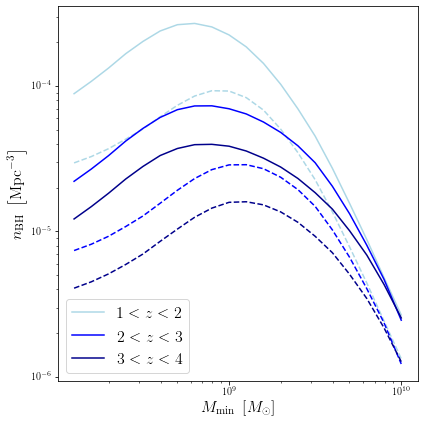

In [464]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

for x in range(len(tab)-1):
    ax.loglog(10**mlis[11:],(4*np.pi/3*(tab[x,11:]*intlam06(mlis[11:])**(1/3))**3)**(-1), label= f'${zlis[x]}<z<{zlis[x+1]}$' ,c=colis[x])
    ax.loglog(10**mlis[11:],(4*np.pi/3*(tab[x,11:]*intlam03(mlis[11:])**(1/3))**3)**(-1), ls='dashed',c=colis[x])

    



ax.legend(loc='lower left',fontsize=16)    
ax.set_xlabel(r'$M_{\rm min}\;\left[{M_\odot}\right]$', fontsize=16)
ax.set_ylabel(r'$n_{\rm BH}\;\left[{\rm Mpc}^{-3}\right]$', fontsize=16)
  
plt.savefig('n_vs_Mz_fopt.pdf')
plt.show()

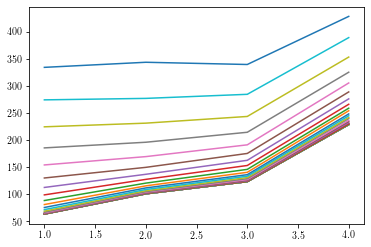

In [458]:
for x in range(len(mlis)):
    plt.plot(zlis,tab[:,x])

plt.show()

## Average distance instead of number density

In [141]:
def dist_Mrange(mlis,mmin,mmax,zlis,zmin,zmax,RA,DEC):
    # restricted arrays
    inds=(mlis>mmin) & (mlis<mmax) & (zlis < zmax) & (zlis > zmin)
    zz=zlis[inds]
    mm=mlis[inds]
    rr=RA[inds]
    dd=DEC[inds]
    # comoving distance to each point
    disdis=cosmo.comoving_distance(zz)
    # cooardiante of each point
    coords = SkyCoord(rr*u.degree, dd*u.degree, frame='icrs', distance = disdis)
    return np.array([np.sort(x.separation_3d(coords).value)[1] for x in coords])

def dist_Mrange_lam06(mlis,mmin,mmax,zlis,zmin,zmax,RA,DEC):
    # restricted arrays
    inds=(mlis>mmin) & (mlis<mmax) & (zlis < zmax) & (zlis > zmin)
    zz=zlis[inds]
    mm=mlis[inds]
    rr=RA[inds]
    dd=DEC[inds]
    lam=intlam06(mm)
    # comoving distance to each point
    disdis=cosmo.comoving_distance(zz)
    # cooardiante of each point
    coords = SkyCoord(rr*u.degree, dd*u.degree, frame='icrs', distance = disdis)
    return np.array([np.sort(x.separation_3d(coords).value*(lam*lam[i])**(1/6))[1] for i,x in enumerate(coords)])


def dist_Mrange_lam03(mlis,mmin,mmax,zlis,zmin,zmax,RA,DEC):
    # restricted arrays
    inds=(mlis>mmin) & (mlis<mmax) & (zlis < zmax) & (zlis > zmin)
    zz=zlis[inds]
    mm=mlis[inds]
    rr=RA[inds]
    dd=DEC[inds]
    lam=intlam03(mm)
    # comoving distance to each point
    disdis=cosmo.comoving_distance(zz)
    # cooardiante of each point
    coords = SkyCoord(rr*u.degree, dd*u.degree, frame='icrs', distance = disdis)
    return np.array([np.sort(x.separation_3d(coords).value*(lam*lam[i])**(1/6))[1] for i,x in enumerate(coords)])

# Angular size of things

In [400]:
cmd_to_add=int1d(logspace(-2,4.1,200),cosmo.angular_diameter_distance(np.array([z_at_value(cosmo.comoving_distance,x*u.Mpc) for x in logspace(-2,4.1,200)])).value)
cmd_to_add(QSO_coord.separation_3d(QSO_coord[1]).value+0.01)


array([1.51303591e+03, 1.00030695e-02, 3.28714737e+02, ...,
       1.76710288e+03, 1.77185431e+03, 1.74851098e+03])

## BH Shadow 

In [582]:
msun_over_Mpc_muas=(5*(const.G*u.M_sun/(const.c**2*u.Mpc))*u.rad).to(u.uas).value


# def cmd_to_add(codist):#co-moving to angular diameter in Mpc
#     return cosmo.angular_diameter_distance(z_at_value(cosmo.comoving_distance,codist*u.Mpc)).to(u.Mpc).value

def BH_shadow_Mrange(mlis,mmin,mmax,zlis,zmin,zmax,RA,DEC):
    # restricted arrays
    inds=(mlis>mmin) & (mlis<mmax) & (zlis < zmax) & (zlis > zmin)
    zz=zlis[inds]
    mm=mlis[inds]
    rr=RA[inds]
    dd=DEC[inds]
    # comoving distance to each point
    disdis=cosmo.comoving_distance(zz)
    # cooardiante of each point
    coords = SkyCoord(rr*u.degree, dd*u.degree, frame='icrs', distance = disdis)
    return np.array([np.sort(msun_over_Mpc_muas*10**((mm+mm[i])/2)/cmd_to_add(x.separation_3d(coords).value+0.01))[-2] for i,x in enumerate(coords)])


def BH_shadow_Mrange_lam06(mlis,mmin,mmax,zlis,zmin,zmax,RA,DEC):
    # restricted arrays
    inds=(mlis>mmin) & (mlis<mmax) & (zlis < zmax) & (zlis > zmin)
    zz=zlis[inds]
    mm=mlis[inds]
    rr=RA[inds]
    dd=DEC[inds]
    lam=intlam06(mm)
    # comoving distance to each point
    disdis=cosmo.comoving_distance(zz)
    # cooardiante of each point
    coords = SkyCoord(rr*u.degree, dd*u.degree, frame='icrs', distance = disdis)
    return np.array([np.sort((lam*lam[i])**(-1/6)*msun_over_Mpc_muas*10**((mm+mm[i])/2)/cmd_to_add(x.separation_3d(coords).value+0.01))[-2] for i,x in enumerate(coords)])

def BH_shadow_Mrange_lam03(mlis,mmin,mmax,zlis,zmin,zmax,RA,DEC):
    # restricted arrays
    inds=(mlis>mmin) & (mlis<mmax) & (zlis < zmax) & (zlis > zmin)
    zz=zlis[inds]
    mm=mlis[inds]
    rr=RA[inds]
    dd=DEC[inds]
    lam=intlam03(mm)
    # comoving distance to each point
    disdis=cosmo.comoving_distance(zz)
    # cooardiante of each point
    coords = SkyCoord(rr*u.degree, dd*u.degree, frame='icrs', distance = disdis)
    return np.array([np.sort((lam*lam[i])**(-1/6)*msun_over_Mpc_muas*10**((mm+mm[i])/2)/cmd_to_add(x.separation_3d(coords).value+0.01))[-2] for i,x in enumerate(coords)])

def BH_shadow_Mrange_minL(mlis,mmin,mmax,zlis,zmin,zmax,RA,DEC):
    # restricted arrays
    inds=(mlis>mmin) & (mlis<mmax) & (zlis < zmax) & (zlis > zmin)
    zz=zlis[inds]
    mm=mlis[inds]
    rr=RA[inds]
    dd=DEC[inds]
    lam=intminL(mm)
    # comoving distance to each point
    disdis=cosmo.comoving_distance(zz)
    # cooardiante of each point
    coords = SkyCoord(rr*u.degree, dd*u.degree, frame='icrs', distance = disdis)
    return np.array([np.sort((lam*lam[i])**(-1/6)*msun_over_Mpc_muas*10**((mm+mm[i])/2)/cmd_to_add(x.separation_3d(coords).value+0.01))[-2] for i,x in enumerate(coords)])

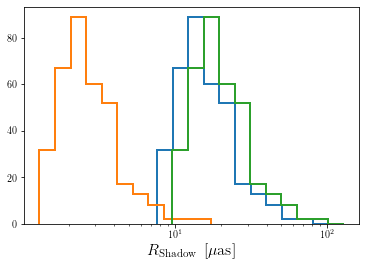

In [504]:
def loghist(data,nbins):
    logbins = np.logspace(np.log10(np.min(data)),np.log10(np.max(data)),nbins)
#     pt=plt.hist(data, bins=logbins,alpha=0.8,histtype='stepfilled',linewidth=3)
    plt.hist(data, bins=logbins,histtype='step',linewidth=2)
    plt.xscale('log')



loghist(BH_shadow_Mrange_lam03(mass_new,10,15,z_new,1,3,ra_new,dec_new),12)
loghist(BH_shadow_Mrange(mass_new,10,15,z_new,1,3,ra_new,dec_new),12)
loghist(BH_shadow_Mrange_lam06(mass_new,10,15,z_new,1,3,ra_new,dec_new),12)
plt.xlabel(r'$R_{\rm Shadow}\;\left[\mu\rm{as}\right]$', fontsize=16)
plt.show()

In [583]:
mbins=np.linspace(8,11,7)
shad_04=np.array([BH_shadow_Mrange_lam03(mass_new,x,x+0.5,z_new,0.4,2.5,ra_new,dec_new) for x in mbins[:-1]])
shad_06=np.array([BH_shadow_Mrange_lam06(mass_new,x,x+0.5,z_new,0.4,2.5,ra_new,dec_new) for x in mbins[:-1]])
shad_minL=np.array([BH_shadow_Mrange_minL(mass_new,x,x+0.5,z_new,0.4,2.5,ra_new,dec_new) for x in mbins[:-1]])


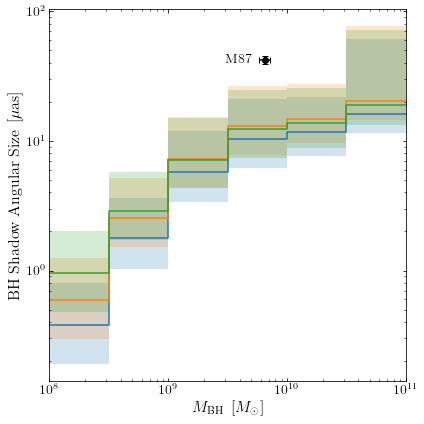

In [646]:
shad_04_p10=np.array([np.percentile(shad_04[i],10) for i,x in enumerate(mbins[:-1])])
shad_04_p10=np.append(shad_04_p10[0],shad_04_p10)
shad_04_p50=np.array([np.percentile(shad_04[i],50) for i,x in enumerate(mbins[:-1])])
shad_04_p50=np.append(shad_04_p50[0],shad_04_p50)
shad_04_p90=np.array([np.percentile(shad_04[i],90) for i,x in enumerate(mbins[:-1])])
shad_04_p90=np.append(shad_04_p90[0],shad_04_p90)

shad_06_p10=np.array([np.percentile(shad_06[i],10) for i,x in enumerate(mbins[:-1])])
shad_06_p10=np.append(shad_06_p10[0],shad_06_p10)
shad_06_p50=np.array([np.percentile(shad_06[i],50) for i,x in enumerate(mbins[:-1])])
shad_06_p50=np.append(shad_06_p50[0],shad_06_p50)
shad_06_p90=np.array([np.percentile(shad_06[i],90) for i,x in enumerate(mbins[:-1])])
shad_06_p90=np.append(shad_06_p90[0],shad_06_p90)

shad_minL_p10=np.array([np.percentile(shad_minL[i],10) for i,x in enumerate(mbins[:-1])])
shad_minL_p10=np.append(shad_minL_p10[0],shad_minL_p10)
shad_minL_p50=np.array([np.percentile(shad_minL[i],50) for i,x in enumerate(mbins[:-1])])
shad_minL_p50=np.append(shad_minL_p50[0],shad_minL_p50)
shad_minL_p90=np.array([np.percentile(shad_minL[i],90) for i,x in enumerate(mbins[:-1])])
shad_minL_p90=np.append(shad_minL_p90[0],shad_minL_p90)

fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
ax.step(10**mbins,shad_04_p50,'-')
ax.fill_between(10**mbins, shad_04_p10,shad_04_p90, alpha=0.2,step="pre")

ax.step(10**mbins,shad_06_p50,'-')
ax.fill_between(10**mbins, shad_06_p10,shad_06_p90, alpha=0.2,step="pre")

ax.step(10**mbins,shad_minL_p50,'-')
ax.fill_between(10**mbins, shad_minL_p10,shad_minL_p90, alpha=0.2,step="pre")

plt.xscale('log')
plt.yscale('log')

# plt.ylim(0,25)
plt.xlim(10**8,10**11)

plt.xlabel(r'$M_{\rm BH}\;\left[M_{\rm \odot}\right]$', fontsize=16)
plt.ylabel(r'${\rm BH\;Shadow\;Angular\;Size}\;\left[\mu{\rm as}\right]$', fontsize=16)

ax.tick_params(which='both',right=True,top=True,direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.errorbar(6.5*10**9,42,3,0.7*10**9,color='black',marker='o',capsize=3)

plt.text(3*10**9,40,r'$\rm{M}87$', fontsize=14)

plt.savefig('shadow.pdf')

plt.show()

### Gravitational Influnce size.

In [581]:
msun_over_Mpc_as=((const.G*u.M_sun/((200*u.km/u.s)**2*u.Mpc))*u.rad).to(u.arcsec).value

# a function that returns M/sig^2 using the M-sig relation, in units of Msun/(200 km/sec)^2
def M_over_sig2(log10M):
    return 7539*10**(0.543379*log10M)
    
def BH_sig_Mrange(mlis,mmin,mmax,zlis,zmin,zmax,RA,DEC):
    # restricted arrays
    inds=(mlis>mmin) & (mlis<mmax) & (zlis < zmax) & (zlis > zmin)
    zz=zlis[inds]
    mm=mlis[inds]
    rr=RA[inds]
    dd=DEC[inds]
    # comoving distance to each point
    disdis=cosmo.comoving_distance(zz)
    # cooardiante of each point
    coords = SkyCoord(rr*u.degree, dd*u.degree, frame='icrs', distance = disdis)
    return np.array([np.sort(msun_over_Mpc_as*M_over_sig2((mm+mm[i])/2)/cmd_to_add(x.separation_3d(coords).value+0.01))[-2] for i,x in enumerate(coords)])


def BH_sig_Mrange_lam06(mlis,mmin,mmax,zlis,zmin,zmax,RA,DEC):
    # restricted arrays
    inds=(mlis>mmin) & (mlis<mmax) & (zlis < zmax) & (zlis > zmin)
    zz=zlis[inds]
    mm=mlis[inds]
    rr=RA[inds]
    dd=DEC[inds]
    lam=intlam06(mm)
    # comoving distance to each point
    disdis=cosmo.comoving_distance(zz)
    # cooardiante of each point
    coords = SkyCoord(rr*u.degree, dd*u.degree, frame='icrs', distance = disdis)
    return np.array([np.sort((lam*lam[i])**(-1/6)*msun_over_Mpc_as*M_over_sig2((mm+mm[i])/2)/cmd_to_add(x.separation_3d(coords).value+0.01))[-2] for i,x in enumerate(coords)])

def BH_sig_Mrange_lam03(mlis,mmin,mmax,zlis,zmin,zmax,RA,DEC):
    # restricted arrays
    inds=(mlis>mmin) & (mlis<mmax) & (zlis < zmax) & (zlis > zmin)
    zz=zlis[inds]
    mm=mlis[inds]
    rr=RA[inds]
    dd=DEC[inds]
    lam=intlam03(mm)
    # comoving distance to each point
    disdis=cosmo.comoving_distance(zz)
    # cooardiante of each point
    coords = SkyCoord(rr*u.degree, dd*u.degree, frame='icrs', distance = disdis)
    return np.array([np.sort((lam*lam[i])**(-1/6)*msun_over_Mpc_as*M_over_sig2((mm+mm[i])/2)/cmd_to_add(x.separation_3d(coords).value+0.01))[-2] for i,x in enumerate(coords)])

def BH_sig_Mrange_minL(mlis,mmin,mmax,zlis,zmin,zmax,RA,DEC):
    # restricted arrays
    inds=(mlis>mmin) & (mlis<mmax) & (zlis < zmax) & (zlis > zmin)
    zz=zlis[inds]
    mm=mlis[inds]
    rr=RA[inds]
    dd=DEC[inds]
    lam=intminL(mm)
    # comoving distance to each point
    disdis=cosmo.comoving_distance(zz)
    # cooardiante of each point
    coords = SkyCoord(rr*u.degree, dd*u.degree, frame='icrs', distance = disdis)
    return np.array([np.sort((lam*lam[i])**(-1/6)*msun_over_Mpc_as*M_over_sig2((mm+mm[i])/2)/cmd_to_add(x.separation_3d(coords).value+0.01))[-2] for i,x in enumerate(coords)])

In [587]:
mbins=np.linspace(8,11,7)
# sig_04=np.array([BH_sig_Mrange_lam03(mass_new,x,x+0.5,z_new,0.4,2.5,ra_new,dec_new) for x in mbins[:-1]])
# sig_06=np.array([BH_sig_Mrange_lam06(mass_new,x,x+0.5,z_new,0.4,2.5,ra_new,dec_new) for x in mbins[:-1]])
sig_minL=np.array([BH_sig_Mrange_minL(mass_new,x,x+0.5,z_new,0.4,2.5,ra_new,dec_new) for x in mbins[:-1]])


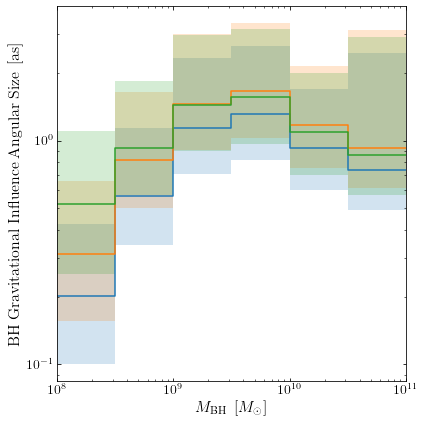

In [623]:
sig_04_p10=np.array([np.percentile(sig_04[i],10) for i,x in enumerate(mbins[:-1])])
sig_04_p10=np.append(sig_04_p10[0],sig_04_p10)
sig_04_p50=np.array([np.percentile(sig_04[i],50) for i,x in enumerate(mbins[:-1])])
sig_04_p50=np.append(sig_04_p50[0],sig_04_p50)
sig_04_p90=np.array([np.percentile(sig_04[i],90) for i,x in enumerate(mbins[:-1])])
sig_04_p90=np.append(sig_04_p90[0],sig_04_p90)

sig_06_p10=np.array([np.percentile(sig_06[i],10) for i,x in enumerate(mbins[:-1])])
sig_06_p10=np.append(sig_06_p10[0],sig_06_p10)
sig_06_p50=np.array([np.percentile(sig_06[i],50) for i,x in enumerate(mbins[:-1])])
sig_06_p50=np.append(sig_06_p50[0],sig_06_p50)
sig_06_p90=np.array([np.percentile(sig_06[i],90) for i,x in enumerate(mbins[:-1])])
sig_06_p90=np.append(sig_06_p90[0],sig_06_p90)

sig_minL_p10=np.array([np.percentile(sig_minL[i],10) for i,x in enumerate(mbins[:-1])])
sig_minL_p10=np.append(sig_minL_p10[0],sig_minL_p10)
sig_minL_p50=np.array([np.percentile(sig_minL[i],50) for i,x in enumerate(mbins[:-1])])
sig_minL_p50=np.append(sig_minL_p50[0],sig_minL_p50)
sig_minL_p90=np.array([np.percentile(sig_minL[i],90) for i,x in enumerate(mbins[:-1])])
sig_minL_p90=np.append(sig_minL_p90[0],sig_minL_p90)

fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

ax.step(10**mbins,sig_04_p50,'-')
ax.fill_between(10**mbins, sig_04_p10,sig_04_p90, alpha=0.2,step="pre")

ax.step(10**mbins,sig_06_p50,'-')
ax.fill_between(10**mbins, sig_06_p10,sig_06_p90, alpha=0.2,step="pre")

ax.step(10**mbins,sig_minL_p50,'-')
ax.fill_between(10**mbins, sig_minL_p10,sig_minL_p90, alpha=0.2,step="pre")

plt.xscale('log')
plt.yscale('log')

ax.tick_params(which='both',right=True,top=True,direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.ylim(0,4)
plt.xlim(10**8,10**11)
plt.xlabel(r'$M_{\rm BH}\;\left[M_{\rm \odot}\right]$', fontsize=16)
plt.ylabel(r'${\rm BH\;Gravitational\;Influence\;Angular\;Size}\;\left[{\rm as}\right]$', fontsize=16)


plt.savefig('gravity.pdf')

plt.show()

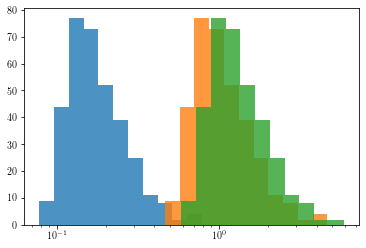

[array([0.83091177, 1.25105093, 2.3455554 ]),
 array([0.65917859, 0.99248322, 1.86077506])]

In [352]:
loghist(BH_sig_Mrange(mass_new,10,15,z_new,1,3,ra_new,dec_new),12)
loghist(BH_sig_Mrange_lam03(mass_new,10,15,z_new,1,3,ra_new,dec_new),12)
loghist(BH_sig_Mrange_lam06(mass_new,10,15,z_new,1,3,ra_new,dec_new),12)
plt.show()

[np.percentile(BH_sig_Mrange_lam06(mass_new,10,15,z_new,1,3,ra_new,dec_new),[10,50,90]),np.percentile(BH_sig_Mrange_lam03(mass_new,10,15,z_new,1,3,ra_new,dec_new),[10,50,90])]


## Distance between pairs of ce

In [136]:
# np.percentile(dist_Mrange(mass_new,9,14,z_new,1,1.5,ra_new,dec_new),[10,90])
# a=np.array([1,10,100,1000])
# np.array([a[j] for i,j in enumerate(a)])
# plt.hist(dist_Mrange_lam06(mass_new,10,15,z_new,0,2,ra_new,dec_new),bins=30)
# plt.show()
pair_dis_06=dist_Mrange_lam06(mass_new,9.5,15,z_new,1,2,ra_new,dec_new)
pair_dis_06_9=dist_Mrange_lam06(mass_new,9,15,z_new,1,2,ra_new,dec_new)

In [208]:
np.mean(intlam06(mass_new[(mass_new>9.5) & (z_new>1) & (z_new<2)]))**(1/3)

0.13349087661368345

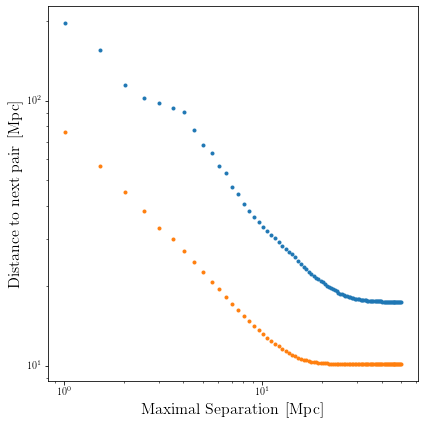

In [211]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
ax.set_ylabel(r'$\rm{Distance\;to\;next\;pair}\;\left[\rm{Mpc}\right]$', fontsize=16)
ax.set_xlabel(r'$\rm{Maximal\;Separation}\;\left[\rm{Mpc}\right]$', fontsize=16)
ax.loglog(np.linspace(0,50,100)[2:],np.mean(intlam06(mass_new[(mass_new>9.5) & (z_new>1) & (z_new<2)]))**(1/3)*(4*np.pi*np.array([pair_dis_06[pair_dis_06<x].shape for x in np.linspace(0,50,100)])[2:]/Vol(1,2).value/3)**(-1/3),'.')
ax.loglog(np.linspace(0,50,100)[2:],np.mean(intlam06(mass_new[(mass_new>9) & (z_new>1) & (z_new<2)]))**(1/3)*(4*np.pi*np.array([pair_dis_06_9[pair_dis_06_9<x].shape for x in np.linspace(0,50,100)])[2:]/Vol(1,2).value/3)**(-1/3),'.')

plt.show()


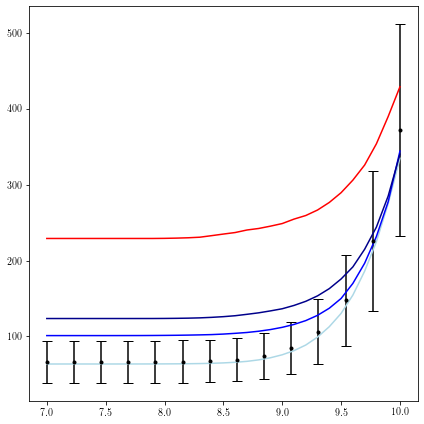

In [423]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
mlis2=np.linspace(7,10,14)

for x in range(len(tab)):
    ax.plot(mlis,tab[x,:], label=r'$z=%1.1f$' % zlis[x],c=colis[x])


ax.errorbar(mlis2,lism,liss,fmt='.',c='black',capsize=5)

plt.savefig('d_vs_Mz_err.pdf')
plt.show()

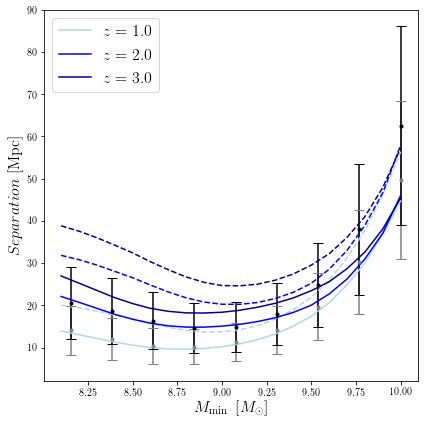

In [424]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

for x in range(len(tab)-1):
    ax.plot(mlis[11:],tab[x,11:]*intlam06(mlis[11:])**(1/3), label=r'$z=%1.1f$' % zlis[x],c=colis[x])
    ax.plot(mlis[11:],tab[x,11:]*intlam03(mlis[11:])**(1/3), ls='dashed',c=colis[x])

    

ax.errorbar(mlis2[5:],lism[5:]*intlam06(mlis2[5:])**(1/3),liss[5:]*intlam06(mlis2[5:])**(1/3),fmt='.',c='gray', capsize=5)
ax.errorbar(mlis2[5:],lism[5:]*intlam03(mlis2[5:])**(1/3),liss[5:]*intlam03(mlis2[5:])**(1/3),fmt='.',c='black', capsize=5)


ax.legend(loc='upper left',fontsize=16)    
ax.set_xlabel(r'$M_{\rm min}\;\left[{M_\odot}\right]$', fontsize=16)
ax.set_ylabel('$Separation\;[\\rm{ Mpc}]$', fontsize=16)
  

plt.savefig('d_vs_Mz_fopt_err.pdf')
plt.show()

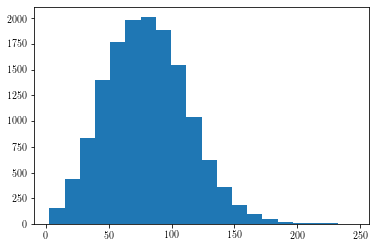

In [382]:
z_max=2
z_min=1
inds=(mass>np.log10(1*10**9)) & (z < z_max) & (dec > 10) & (dec < 50) & (ra > 120) & (ra < 240) & (z > z_min) 
z_new=z[inds]
dec_new=dec[inds]
ra_new=ra[inds]
mass_new=mass[inds]
dist_new=cosmo.comoving_distance(z_new)
QSO_coord = SkyCoord(ra_new*u.degree, dec_new*u.degree, frame='icrs', distance = dist_new)
dist_arr=np.array([np.sort(x.separation_3d(QSO_coord).value)[1] for x in QSO_coord])
# lism=np.append(lism,np.mean(dist_arr))
# liss=np.append(liss,np.std(dist_arr))
plt.hist(dist_arr,bins=20)
plt.show()

In [383]:
np.sort(dist_arr)

array([  2.95074337,   2.95074337,   3.80915544, ..., 240.82480706,
       242.32671037, 244.73210421])

## 2D Histogram of the relevant region in space

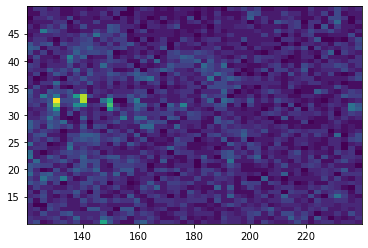

In [14]:


fig=hist2d(ra_new,dec_new, bins=50)

plt.show()

# gammas = [0.8, 0.5, 0.3]

# fig, axs = plt.subplots(nrows=2, ncols=2)

# axs[0, 0].set_title('Linear normalization')
# axs[0, 0].hist2d(ra_new,dec_new, bins=100)

# for ax, gamma in zip(axs.flat[1:], gammas):
#     ax.set_title(r'Power law $(\gamma=%1.1f)$' % gamma)
#     ax.hist2d(ra_new,dec_new, bins=100, norm=mcolors.PowerNorm(gamma))

# fig.tight_layout()

# plt.show()



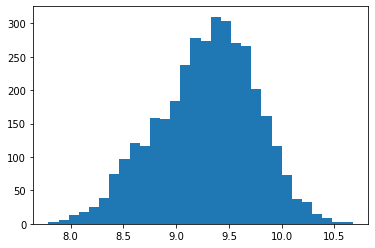

In [13]:
z_max=4
z_min=3
m_min=1
inds=(mass>m_min) & (z < z_max) & (dec > 10) & (dec < 50) & (ra > 120) & (ra < 240) & (z > z_min) 

mass_new=mass[inds]


plt.hist(mass_new,bins=30)
plt.show()

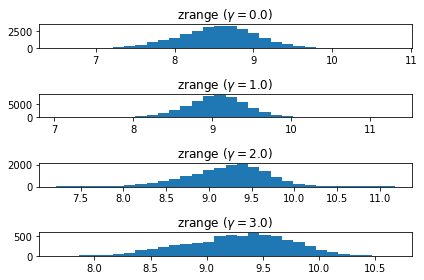

In [24]:
zlis = [[0,1],[1,2],[2,3],[3,4]]

fig, axs = plt.subplots(nrows=4, ncols=1)
for ax, zz in zip(axs.flat,zlis):
    ax.set_title(r'z range $(\gamma=%1.1f)$' % zz[0])
    ax.hist(mass[(mass>0) & (z<zz[1])& (zz[0]<z)],bins=30)


fig.tight_layout()

plt.show()

In [17]:
zip(axs.flat[1:], gammas)

# A la Random

In [788]:
npoints=50
rand_ra=ra_min+(ra_max-ra_min)*(np.random.random_sample((npoints)))
rand_dec=dec_min+(dec_max-dec_min)*(np.random.random_sample((npoints)))
rand_z=0.4+(2.5-0.4)*(np.random.random_sample((npoints)))
rand_dist=cosmo.comoving_distance(rand_z)

In [682]:
dis=np.array([])
mis=np.array([])
for ra

In [789]:
cory=np.array([SkyCoord(rr*u.degree, dd*u.degree, frame='icrs', distance = zz) for rr in rand_ra for dd in rand_dec for zz in rand_dist])

In [908]:
sinds=(mass_new>8) & (mass_new<10.5)
smass=mass_new[sinds]
sz=z_new[sinds]
sra=ra_new[sinds]
sdec=dec_new[sinds]
sdis=cosmo.comoving_distance(sz)
slam=intminL(smass)
scoords = SkyCoord(sra*u.degree, sdec*u.degree, frame='icrs', distance = sdis)


In [946]:
def m_dis_lis(x):
    tlis=(slam)**(-1/3)*msun_over_Mpc_as*M_over_sig2(smass)/cmd_to_add(x.separation_3d(scoords).value+0.01)
    arg=np.argmax(tlis)
    return np.array([smass[arg],tlis[arg]])

import time
start_time = time.time()



fin=np.array([m_dis_lis(x) for x in cory[:30000]])

print("--- %s seconds ---" % (time.time() - start_time))

--- 294.7720248699188 seconds ---


In [947]:
def m_shad_lis(x):
    tlis=(slam)**(-1/3)*msun_over_Mpc_muas*10**(smass)/cmd_to_add(x.separation_3d(scoords).value+0.01)
    arg=np.argmax(tlis)
    return np.array([smass[arg],tlis[arg]])

fin2=np.array([m_shad_lis(x) for x in cory[:30000]])

In [971]:
llll[[1,2]]

array([2, 3])

In [992]:
def m_shad_lis23(x):
    tlis=(slam)**(-1/3)*msun_over_Mpc_muas*10**(smass)/cmd_to_add(x.separation_3d(scoords).value+0.01)
    max1=np.max(tlis)
    max2=np.max(tlis[tlis!=max1])
    max3=np.max(tlis[(tlis!=max1) & (tlis!=max2)])
    return np.array([max1,max2,max3])


def m_dis_lis23(x):
    tlis=(slam)**(-1/3)*msun_over_Mpc_as*M_over_sig2(smass)/cmd_to_add(x.separation_3d(scoords).value+0.01)
    max1=np.max(tlis)
    max2=np.max(tlis[tlis!=max1])
    max3=np.max(tlis[(tlis!=max1) & (tlis!=max2)])
    return np.array([max1,max2,max3])

# shad123=np.array([m_shad_lis23(x) for x in cory[:10000]])
grav123=np.array([m_dis_lis23(x) for x in cory[:10000]])

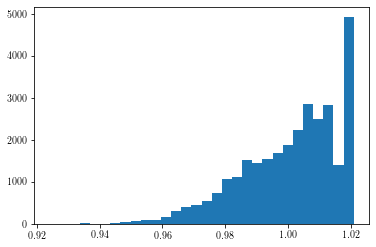

In [953]:
plt.hist(np.log10(fin2[:,0]),bins=30)
plt.show()

In [794]:
from getdist import plots, MCSamples
import getdist

Removed no burn in


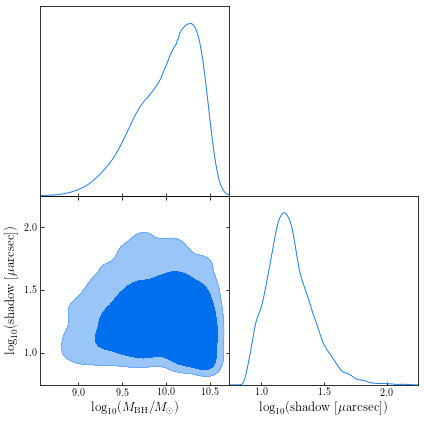

In [996]:
names2 = ["x%s"%i for i in range(2)]
labels2 =  ['$\log_{10}(M_{\\rm{BH}}/M_\odot)$' , '$\log_{10}(\\rm{shadow}\;[\mu\\rm{arcsec}])$']

logfin2=np.transpose(np.vstack((fin2[:,0],np.log10(fin2[:,1]))))


samples2 = MCSamples(samples=logfin2,names = names2, labels = labels2,settings={'smooth_scale_2D':0.3,'contours': [0.90, 0.99]})


# g = plots.get_single_plotter(width_inch=4, ratio=1)
# g.plot_2d(samples, 'x0', 'x1', filled=True)
# g.add_legend(['sim 1', 'sim 2'], colored_text=True);

# Triangle plot
g = plots.get_subplot_plotter(subplot_size=3)
g.triangle_plot(samples2, filled=True)

plt.savefig('shadow_tri.pdf')

Removed no burn in


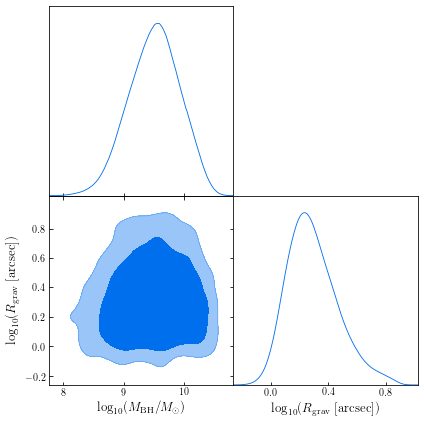

In [997]:
names = ["x%s"%i for i in range(2)]
labels =  ['$\log_{10}(M_{\\rm{BH}}/M_\odot)$' , '$\log_{10}(R_{\\rm {grav}}\;[\\rm{arcsec}])$']

logfin=np.transpose(np.vstack((fin[:,0],np.log10(fin[:,1]))))[fin[:,1]<8]


samples = MCSamples(samples=logfin,names = names, labels = labels,settings={'smooth_scale_2D':0.3,'contours': [0.90, 0.99]})


# g = plots.get_single_plotter(width_inch=4, ratio=1)
# g.plot_2d(samples, 'x0', 'x1', filled=True)
# g.add_legend(['sim 1', 'sim 2'], colored_text=True);

# Triangle plot
g = plots.get_subplot_plotter(subplot_size=3)
g.triangle_plot(samples, filled=True)

plt.savefig('gravi_tri.pdf')

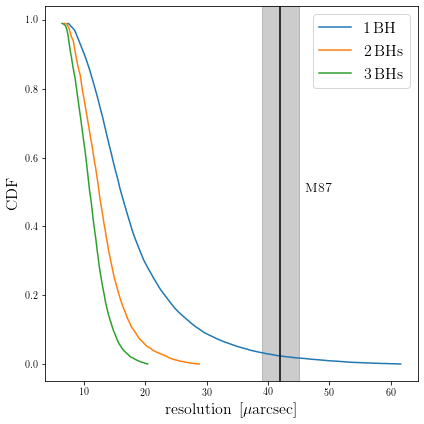

In [998]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True) 
ax.plot(np.percentile(fin2[:,1],99-linspace(0,99,1000)),linspace(0,99,1000)/100 ,label=r'$1\,\rm{BH}$')
# ax.plot(np.percentile(shad123[:,0],99-linspace(0,99,1000)),linspace(0,99,1000)/100 ,label=r'$1\,\rm{BH}$')
ax.plot(np.percentile(shad123[:,1],99-linspace(0,99,1000)),linspace(0,99,1000)/100 ,label=r'$2\,\rm{BHs}$')
ax.plot(np.percentile(shad123[:,2],99-linspace(0,99,1000)),linspace(0,99,1000)/100 ,label=r'$3\,\rm{BHs}$')
ax.axvline(x=42,color='black')
ax.axvspan(42-3, 42+3, alpha=0.2, color='black')

ax.set_xlabel(r'$\rm resolution\;\left[\mu{\rm arcsec}\right]$', fontsize=16)
ax.set_ylabel(r'$\rm CDF$', fontsize=16)

ax.legend(loc='upper right',fontsize=16)  

plt.text(46, 0.5,r'$\rm{M}87$', fontsize=14)

plt.savefig('shadow_CDF.pdf')
plt.show()

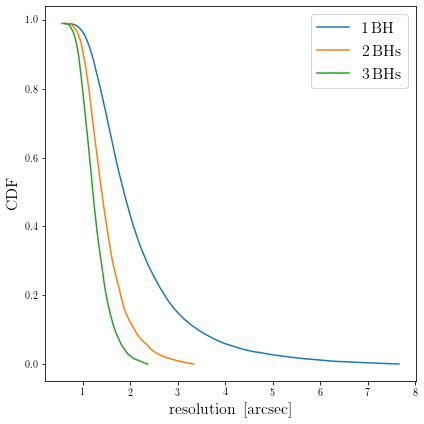

In [999]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True) 
ax.plot(np.percentile(fin[:,1],99-linspace(0,99,1000)),linspace(0,99,1000)/100 ,label=r'$1\,\rm{BH}$')
# ax.plot(np.percentile(grav123[:,0],99-linspace(0,99,1000)),linspace(0,99,1000)/100 ,label=r'$1\,\rm{BH}$')
ax.plot(np.percentile(grav123[:,1],99-linspace(0,99,1000)),linspace(0,99,1000)/100 ,label=r'$2\,\rm{BHs}$')
ax.plot(np.percentile(grav123[:,2],99-linspace(0,99,1000)),linspace(0,99,1000)/100 ,label=r'$3\,\rm{BHs}$')
# ax.axvline(x=42,color='black')
# ax.axvspan(42-3, 42+3, alpha=0.2, color='black')

ax.set_xlabel(r'$\rm resolution\;\left[{\rm arcsec}\right]$', fontsize=16)
ax.set_ylabel(r'$\rm CDF$', fontsize=16)

ax.legend(loc='upper right',fontsize=16)  

# plt.text(46, 0.5,r'$\rm{M}87$', fontsize=14)

plt.savefig('gravi_CDF.pdf')
plt.show()

In [1005]:
np.sort(shad123[:,1])[:10]

array([6.80527692, 6.86777935, 6.87344477, 6.87381923, 6.88371305,
       6.88659288, 6.90341282, 6.92245406, 6.94809754, 6.98471241])